<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [5]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\jiaha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: c:\Users\jiaha\Documents\Universidad\TVD\Voice-and-Dialogue-Treatment\Lab2\nlu_ATIS_data.tar.gz

  0%|          | 0.00/122k [00:00<?, ?B/s]
100%|██████████| 122k/122k [00:00<00:00, 2.48MB/s]


In [2]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [3]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [5]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  what 's the fare from washington to boston
Intent:  airfare


A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [6]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: abbreviation
Label 1: airport
Label 2: flight_no
Label 3: ground_fare
Label 4: capacity
Label 5: ground_service
Label 6: flight+airfare
Label 7: flight
Label 8: flight_time
Label 9: distance
Label 10: ground_service+ground_fare
Label 11: airline+flight_no
Label 12: restriction
Label 13: aircraft
Label 14: airfare
Label 15: cheapest
Label 16: aircraft+flight+flight_no
Label 17: quantity
Label 18: city
Label 19: airfare+flight_time
Label 20: meal
Label 21: airline

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [9]:
num_words=500 # We will only use the top 500 words in the dataset, other words will be considered as out-of-vocabulary
tokenizer = Tokenizer(num_words)
# tokenizer = Tokenizer(num_words, oov_token="<OOV>") out-of-vocabulary token
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)
print(len(vocab))

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [10]:
#TODO
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [11]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [12]:
#TODO
train_pad_sequences = pad_sequences(train_sequences, padding='post', maxlen=100)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
```


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [13]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [14]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')


Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [15]:
#TODO
val_sentences = list(val_data[0])
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_pad_sequences = pad_sequences(val_sequences, padding='post', maxlen=100)
print(len(val_pad_sequences), len(val_sequences))

test_sentences = list(test_data[0])
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_pad_sequences = pad_sequences(test_sequences, padding='post', maxlen=100)
print(len(test_pad_sequences), len(test_sequences))


900 900
893 893


In [16]:
val_labels = list(val_data[2])
val_labels = list(s.replace('"', '') for s in val_labels)
val_labels = list(s.replace(' ', '') for s in val_labels)

test_labels = list(test_data[2])
test_labels = list(s.replace('"', '') for s in test_labels)
test_labels = list(s.replace(' ', '') for s in test_labels)

def remove_values_and_indices(input_list, values_to_remove, other_list):
    #print(f'Initial {len(input_list)} samples')
    #print(f'Initial {len(other_list)} samples')
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    #print(f'Removing {len(indices_to_remove)} samples')
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    #print(f'Remaining {len(cleaned_list)} samples')
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    #print(f'Remaining {len(cleaned_other_list)} samples')
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline', 'flight']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)

In [17]:
val_encoded_labels = to_categorical(label_encoder.transform(val_labels), num_classes)
test_encoded_labels = to_categorical(label_encoder.transform(test_labels), num_classes)
print('Validation labels shape:', val_encoded_labels.shape)
print('Test labels shape:', test_encoded_labels.shape)


Validation labels shape: (257, 22)
Test labels shape: (256, 22)


In [18]:
print(val_labels[0], val_pad_sequences[0], val_encoded_labels[0])
print(test_labels[0], test_pad_sequences[0], test_encoded_labels[0])

aircraft [  6 212  29 287  20 205   5   4  76   8   2   9   1  11  15  67   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
airfare [  5 266  41  12  55  14 171   2 172   1  11 165 177  59 163  84   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [19]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [51]:
# Importar métricas
from tensorflow.keras.metrics import F1Score

# Modelo
embedding_dim = 500
vocab_size = num_words + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))  # layer 1
model.add(GlobalMaxPooling1D(data_format='channels_last'))  # layer 2
model.add(Dense(128, activation='relu'))  # layer 3
model.add(Dense(num_classes, activation='softmax'))  # layer 4

metrics = tf.keras.metrics.F1Score(average='macro')
# Compile con métricas básicas
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = [metrics]
)

# Train
batch_size = 32
epochs = 10
model.fit(
    train_pad_sequences,
    train_encoded_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_pad_sequences, val_encoded_labels)
)

# Evaluation (Keras devuelve las métricas indicadas)
results = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size, return_dict=True)
print(f'Test Loss: {results["loss"]:.4f}')
print(f'Test F1 Score: {results["f1_score"]:.4f}')

Epoch 1/10


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - f1_score: 0.0455 - loss: 1.4202 - val_f1_score: 0.1102 - val_loss: 2.0962
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.1726 - loss: 0.5939 - val_f1_score: 0.2049 - val_loss: 1.2460
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2673 - loss: 0.3050 - val_f1_score: 0.2318 - val_loss: 0.8898
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.3059 - loss: 0.1707 - val_f1_score: 0.2715 - val_loss: 0.7718
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.4632 - loss: 0.1316 - val_f1_score: 0.3230 - val_loss: 0.6653
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.5706 - loss: 0.0889 - val_f1_score: 0.4024 - val_loss: 0.6391
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_score: 0.5851 - loss: 0.0596 - val_f1_score: 0.4507 - val_loss: 0.5416
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.6285 - loss: 0.0399 - val_f1_score: 0.4931 - val_

Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [42]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

Experimentar amb mida de vocabulari i embesdings, metriques (acuracy si clase balancejar, f1-score si no), cambiar el poling, 

In [1]:
from jiahao_funcs import *

In [4]:
(train_pad_sequences, train_encoded_labels, val_pad_sequences, val_encoded_labels,
 test_pad_sequences, test_encoded_labels, num_classes, maxlen,tokenizer) = preprocess(train_data, val_data, 
                                                                                      test_data, num_words=500)
vocab_size = len(tokenizer.word_index)

-------Running embedding_dim=50  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=0.6286
  run 2/5 done | last val_loss=0.7778
  run 3/5 done | last val_loss=0.8341
  run 4/5 done | last val_loss=0.9886
  run 5/5 done | last val_loss=0.7254
Finished embedding_dim=50  |  averaged last val_loss=0.7909
-------Running embedding_dim=100  (5 runs)...---------
  run 1/5 done | last val_loss=0.7152
  run 2/5 done | last val_loss=0.7896
  run 3/5 done | last val_loss=0.7460
  run 4/5 done | last val_loss=0.8009
  run 5/5 done | last val_loss=0.5622
Finished embedding_dim=100  |  averaged last val_loss=0.5622
-------Running embedding_dim=200  (5 runs)...---------
  run 1/5 done | last val_loss=0.6796
  run 2/5 done | last val_loss=0.7533
  run 3/5 done | last val_loss=0.6662
  run 4/5 done | last val_loss=0.7537
  run 5/5 done | last val_loss=0.6068
Finished embedding_dim=200  |  averaged last val_loss=0.6432


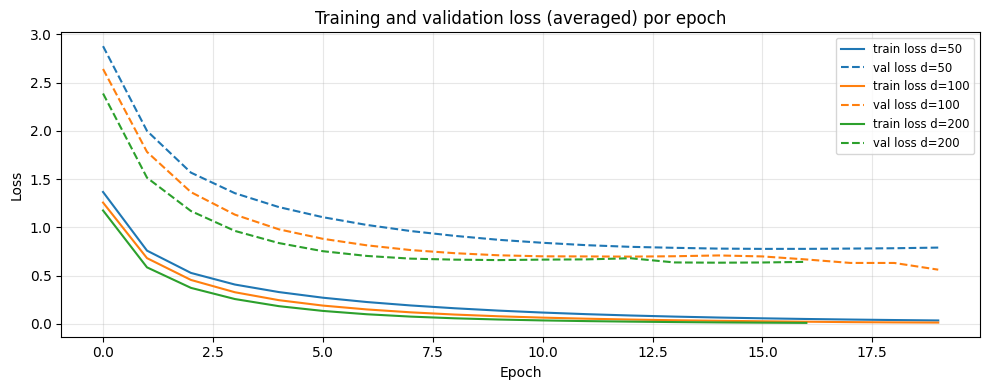

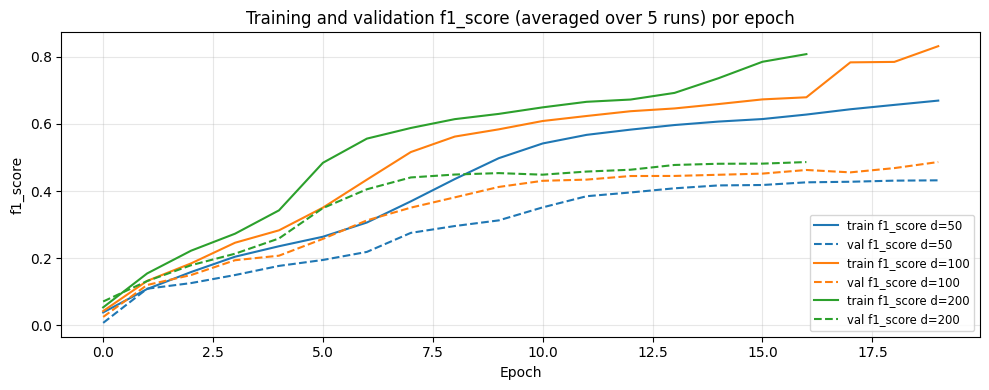

{50: {'f1_score': array([0.03843327, 0.10810886, 0.15876214, 0.20440951, 0.2356134 ,
         0.26389744, 0.30630944, 0.3693871 , 0.43572872, 0.49795111,
         0.5418901 , 0.56752706, 0.58311259, 0.59677851, 0.60709351,
         0.61463448, 0.6280051 , 0.64376658, 0.65680294, 0.6695861 ]),
  'loss': array([1.36702366, 0.75942866, 0.5285107 , 0.40811683, 0.33022609,
         0.27189693, 0.22707672, 0.19154416, 0.16243524, 0.1380845 ,
         0.11796127, 0.1013352 , 0.0875557 , 0.07610042, 0.06640623,
         0.05834145, 0.05142544, 0.04553338, 0.04052065, 0.03615295]),
  'val_f1_score': array([0.00719669, 0.10900579, 0.12583876, 0.14977738, 0.17700372,
         0.19469651, 0.21868752, 0.27541943, 0.29582979, 0.31260936,
         0.35142255, 0.38466749, 0.39588475, 0.4082448 , 0.41684105,
         0.41809999, 0.42605412, 0.42776297, 0.43105894, 0.43200736]),
  'val_loss': array([2.87722793, 1.99951091, 1.56731665, 1.35417571, 1.21056969,
         1.10582626, 1.02550168, 0.96219877, 

In [5]:
provar_embeddings(train_pad_sequences, train_encoded_labels, 
                  val_pad_sequences, val_encoded_labels, vocab_size, num_classes,
                  batch_size=32, epochs=20,
                  maxlen=maxlen, embedding_dims=[50, 100, 200])


<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---